In [2]:
%load_ext autoreload
%autoreload 2

import json
import sys
import os
import re
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import wordnet as wn
import seaborn as sns

from scipy.stats import kruskal
sys.path.insert(0, "generate_abstractions")

from utils import SYSTEM_PROMPTS, rename, get_violin_plot, get_box_plot, get_bubble_plot, get_closure_size
np.random.seed(1)

In [3]:
df = pd.read_csv("data/Brysb_concrete+abstract-no_multiple-inheritance-judgements_specificity-wnType-20190227-correct.csv")
# df = pd.read_csv("/home/gpucce/Repos/abstract_llm/data/Scores_Conc_and_Spec_for_study1.csv")

<Axes: >

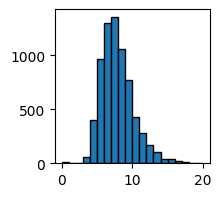

In [4]:
df["closure_size"] = df["token"].map(get_closure_size)
df["closure_size"].hist(figsize=(2, 2), bins=20, grid=False, linewidth=1, edgecolor='black')

In [5]:
abstract_tokens = df.loc[df.wn_type == "abstract", "token"].values
concrete_tokens = df.loc[df.wn_type == "concrete", "token"].values

In [6]:
data_path = "./processed_gender_prompts/"
_files = os.listdir(data_path)

data = {i:{} for i in SYSTEM_PROMPTS.keys()}
for _file in _files:

    if not "405" in _file:
        continue

    with open(data_path + _file) as f:
        _origin_read_file = [json.loads(i) for i in f.readlines()]

    # remove None values
    _read_file = [i for i in _origin_read_file if i["list"] is not None or i["list_spec"] is not None or i["list_spec_corr"] is not None]
    _read_file = [i for i in _read_file if isinstance(i["list_spec_corr"], float) and not np.isnan(i["list_spec_corr"])]
    _read_file = [i for i in _read_file if len([j for j in i["list_spec"] if 0 < j < 15]) > 2]

    for i in _read_file:
        i["wn_type"] = "abstract" if i["token"] in abstract_tokens else "concrete"

    for i in data:
        prompt = _file.split("_")[-1].split(".")[0] + "."
        if prompt in SYSTEM_PROMPTS[i]:
            data[i][prompt] = _read_file

# Linguist Example

# Age Prompts

In [7]:
def is_age_prompt(p):
    return re.search(r"\d+ ", p)

def get_age_prompts(x):
    return {i: j for i,j in x.items() if is_age_prompt(i)}

def get_no_age_prompts(x):
    return {i: j for i,j in x.items() if not is_age_prompt(i)}

In [8]:
all_age_prompts = {"generic_prompts":{}, "female_prompts":{}, "male_prompts":{}}
for prompt_kind in ["generic_prompts", "female_prompts", "male_prompts"]:
    for wn_type in ["abstract", "concrete", None]:

        age_prompts = get_age_prompts(data[prompt_kind])
        age_prompts = {i:j for i,j in sorted(age_prompts.items(), key=lambda x: int(re.search(r"\d+ ", x[0]).group(0)))}
        if wn_type is not None:
            age_prompts = {i:[k for k in j if k["wn_type"] == wn_type] for i, j in age_prompts.items()}
        all_age_prompts[prompt_kind][wn_type] = age_prompts
        out_name = "age_" + prompt_kind.split("_")[0] + "_violin_plot.pdf"
        if wn_type is not None:
            out_name = wn_type + "_" + out_name
        out_name = "plots/" + out_name
        # fig = get_violin_plot(age_prompts, out_name)

        out_name = out_name.replace("violin", "box")
        # fig = get_box_plot(age_prompts, out_name)

# Non Age Prompts

In [9]:
all_no_age_prompts = {"generic_prompts":{}, "female_prompts":{}, "male_prompts":{}}
for prompt_kind in ["generic_prompts", "female_prompts", "male_prompts"]:
    for wn_type in ["abstract", "concrete", None]:
        no_age_prompts = get_no_age_prompts(data[prompt_kind])
        if wn_type is not None:
            no_age_prompts = {i:[k for k in j if k["wn_type"] == wn_type] for i, j in no_age_prompts.items()}
        all_no_age_prompts[prompt_kind][wn_type] = no_age_prompts
        out_name = "no_age_" + prompt_kind.split("_")[0] + "_violin_plot.pdf"
        if wn_type is not None:
            out_name = wn_type + "_" + out_name
        out_name = "plots/" + out_name
        # fig = get_violin_plot(no_age_prompts, out_name)

        out_name = out_name.replace("violin", "box")
        # fig = get_box_plot(no_age_prompts, out_name)

In [10]:
samples = [[i["list_spec_corr"] for i in j] for j in all_no_age_prompts["generic_prompts"][None].values()]

In [11]:
all_no_age_prompts_list = []
for k in all_no_age_prompts:
    all_no_age_prompts_list += list(all_no_age_prompts[k][None].keys())
all_age_prompts_list = []
for k in all_age_prompts:
    all_age_prompts_list += list(all_age_prompts[k][None].keys())

def get_pvals(all_prompts, all_prompts_list):
    pvals = {}
    for i, j in list(combinations(all_prompts_list, 2)):
        if i not in pvals:
            pvals[i] = {}
        prompt_kind_i = [prompt_kind for prompt_kind in all_prompts if i in all_prompts[prompt_kind][None]][0]
        prompt_kind_j = [prompt_kind for prompt_kind in all_prompts if j in all_prompts[prompt_kind][None]][0]
        test = kruskal(
            [i["list_spec_corr"] for i in all_prompts[prompt_kind_i][None][i]],
            [i["list_spec_corr"] for i in all_prompts[prompt_kind_j][None][j]])
        pvals[i][j] = test[1]
    return pvals

pvals_age = get_pvals(all_age_prompts, all_age_prompts_list)
pvals_no_age = get_pvals(all_no_age_prompts, all_no_age_prompts_list)

In [12]:
pvals_renamed_age = rename(pvals_age)
pvals_renamed_no_age = rename(pvals_no_age, kind="no_age")

In [13]:
# sns.heatmap(pd.DataFrame.from_dict(pvals_renamed_no_age).T);

In [14]:
# fig, ax = plt.subplots(1,1, figsize=(10, 10))
# sns.heatmap(pd.DataFrame.from_dict(pvals_age).T, ax=ax);

In [15]:
# _plot_data_no_age = pd.DataFrame.from_dict(pvals_renamed_no_age).T
# bubble_fig_no_age = get_bubble_plot(_plot_data_no_age, size_factor=500)

In [16]:
# _plot_data_age = pd.DataFrame.from_dict(pvals_renamed_age).T
# bubble_fig_age = get_bubble_plot(_plot_data_age, size_factor=200)

# Length Investigation

In [17]:
def plot_lengths(ladder_list, output_path, ax=None, high_val=6500):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_axisbelow(True)
    ax.yaxis.grid(color= 'gray', linewidth = 0.5)
    ax.hist([len(i["list"]) for i in ladder_list], bins=[i + 0.5 for i in range(6, 25)], align="mid",
            edgecolor="black", linewidth=1, color="skyblue", alpha=1.0, label="N. Ladders");
    ax.set_ylim(0, high_val)
    ax.set_xlabel("Ladder Length", fontsize=20)
    ax.set_ylabel("Number of ladders", fontsize=20)
    ax.set_yticks([1000 * i for i in range(1, 1 + int(high_val / 1000), 2)])
    # ax.set_yticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, fontsize=15)
    for l in ax.get_yticklabels():
        l.set_va("center")
    # ax.legend()
    ax.set_xticks(range(6, 25, 2));
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    if fig is not None:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    return fig, ax

In [18]:
linguist_ladders = data["generic_prompts"]["You are an expert linguist analysing the abstraction and concreteness of words."]
child_ladders = data["generic_prompts"]["You are a child of 3 years old learning about the world."]
adult_ladders = data["generic_prompts"]["You are a young adult of 30 years old learning in a professional setting."]
senior_ladders = data["generic_prompts"]["You are a senior of 70 years old who is now retired."]

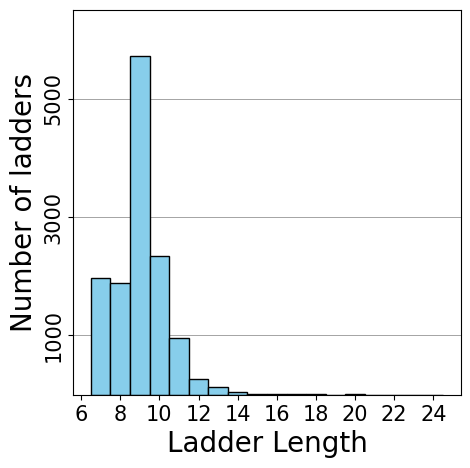

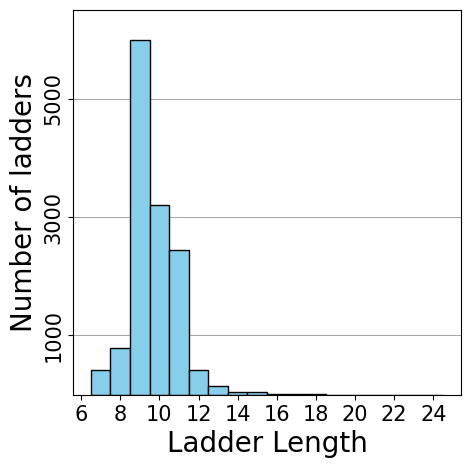

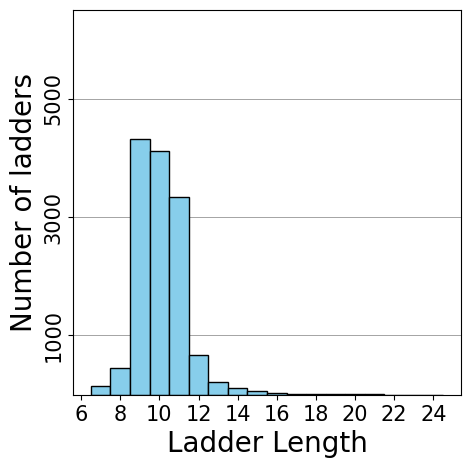

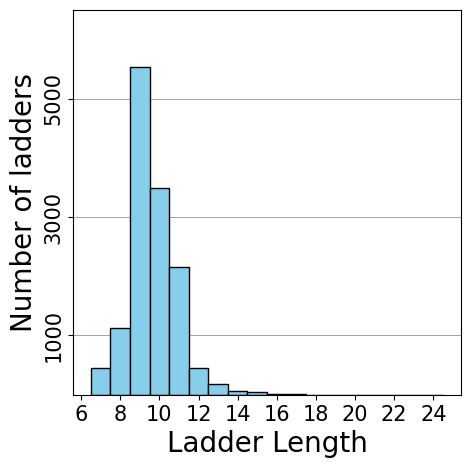

In [19]:
plot_lengths(child_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/child_ladders_length.pdf");
plot_lengths(adult_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/adult_ladders_length.pdf");
plot_lengths(linguist_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/linguist_ladders_length.pdf");
plot_lengths(senior_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/senior_ladders_length.pdf");

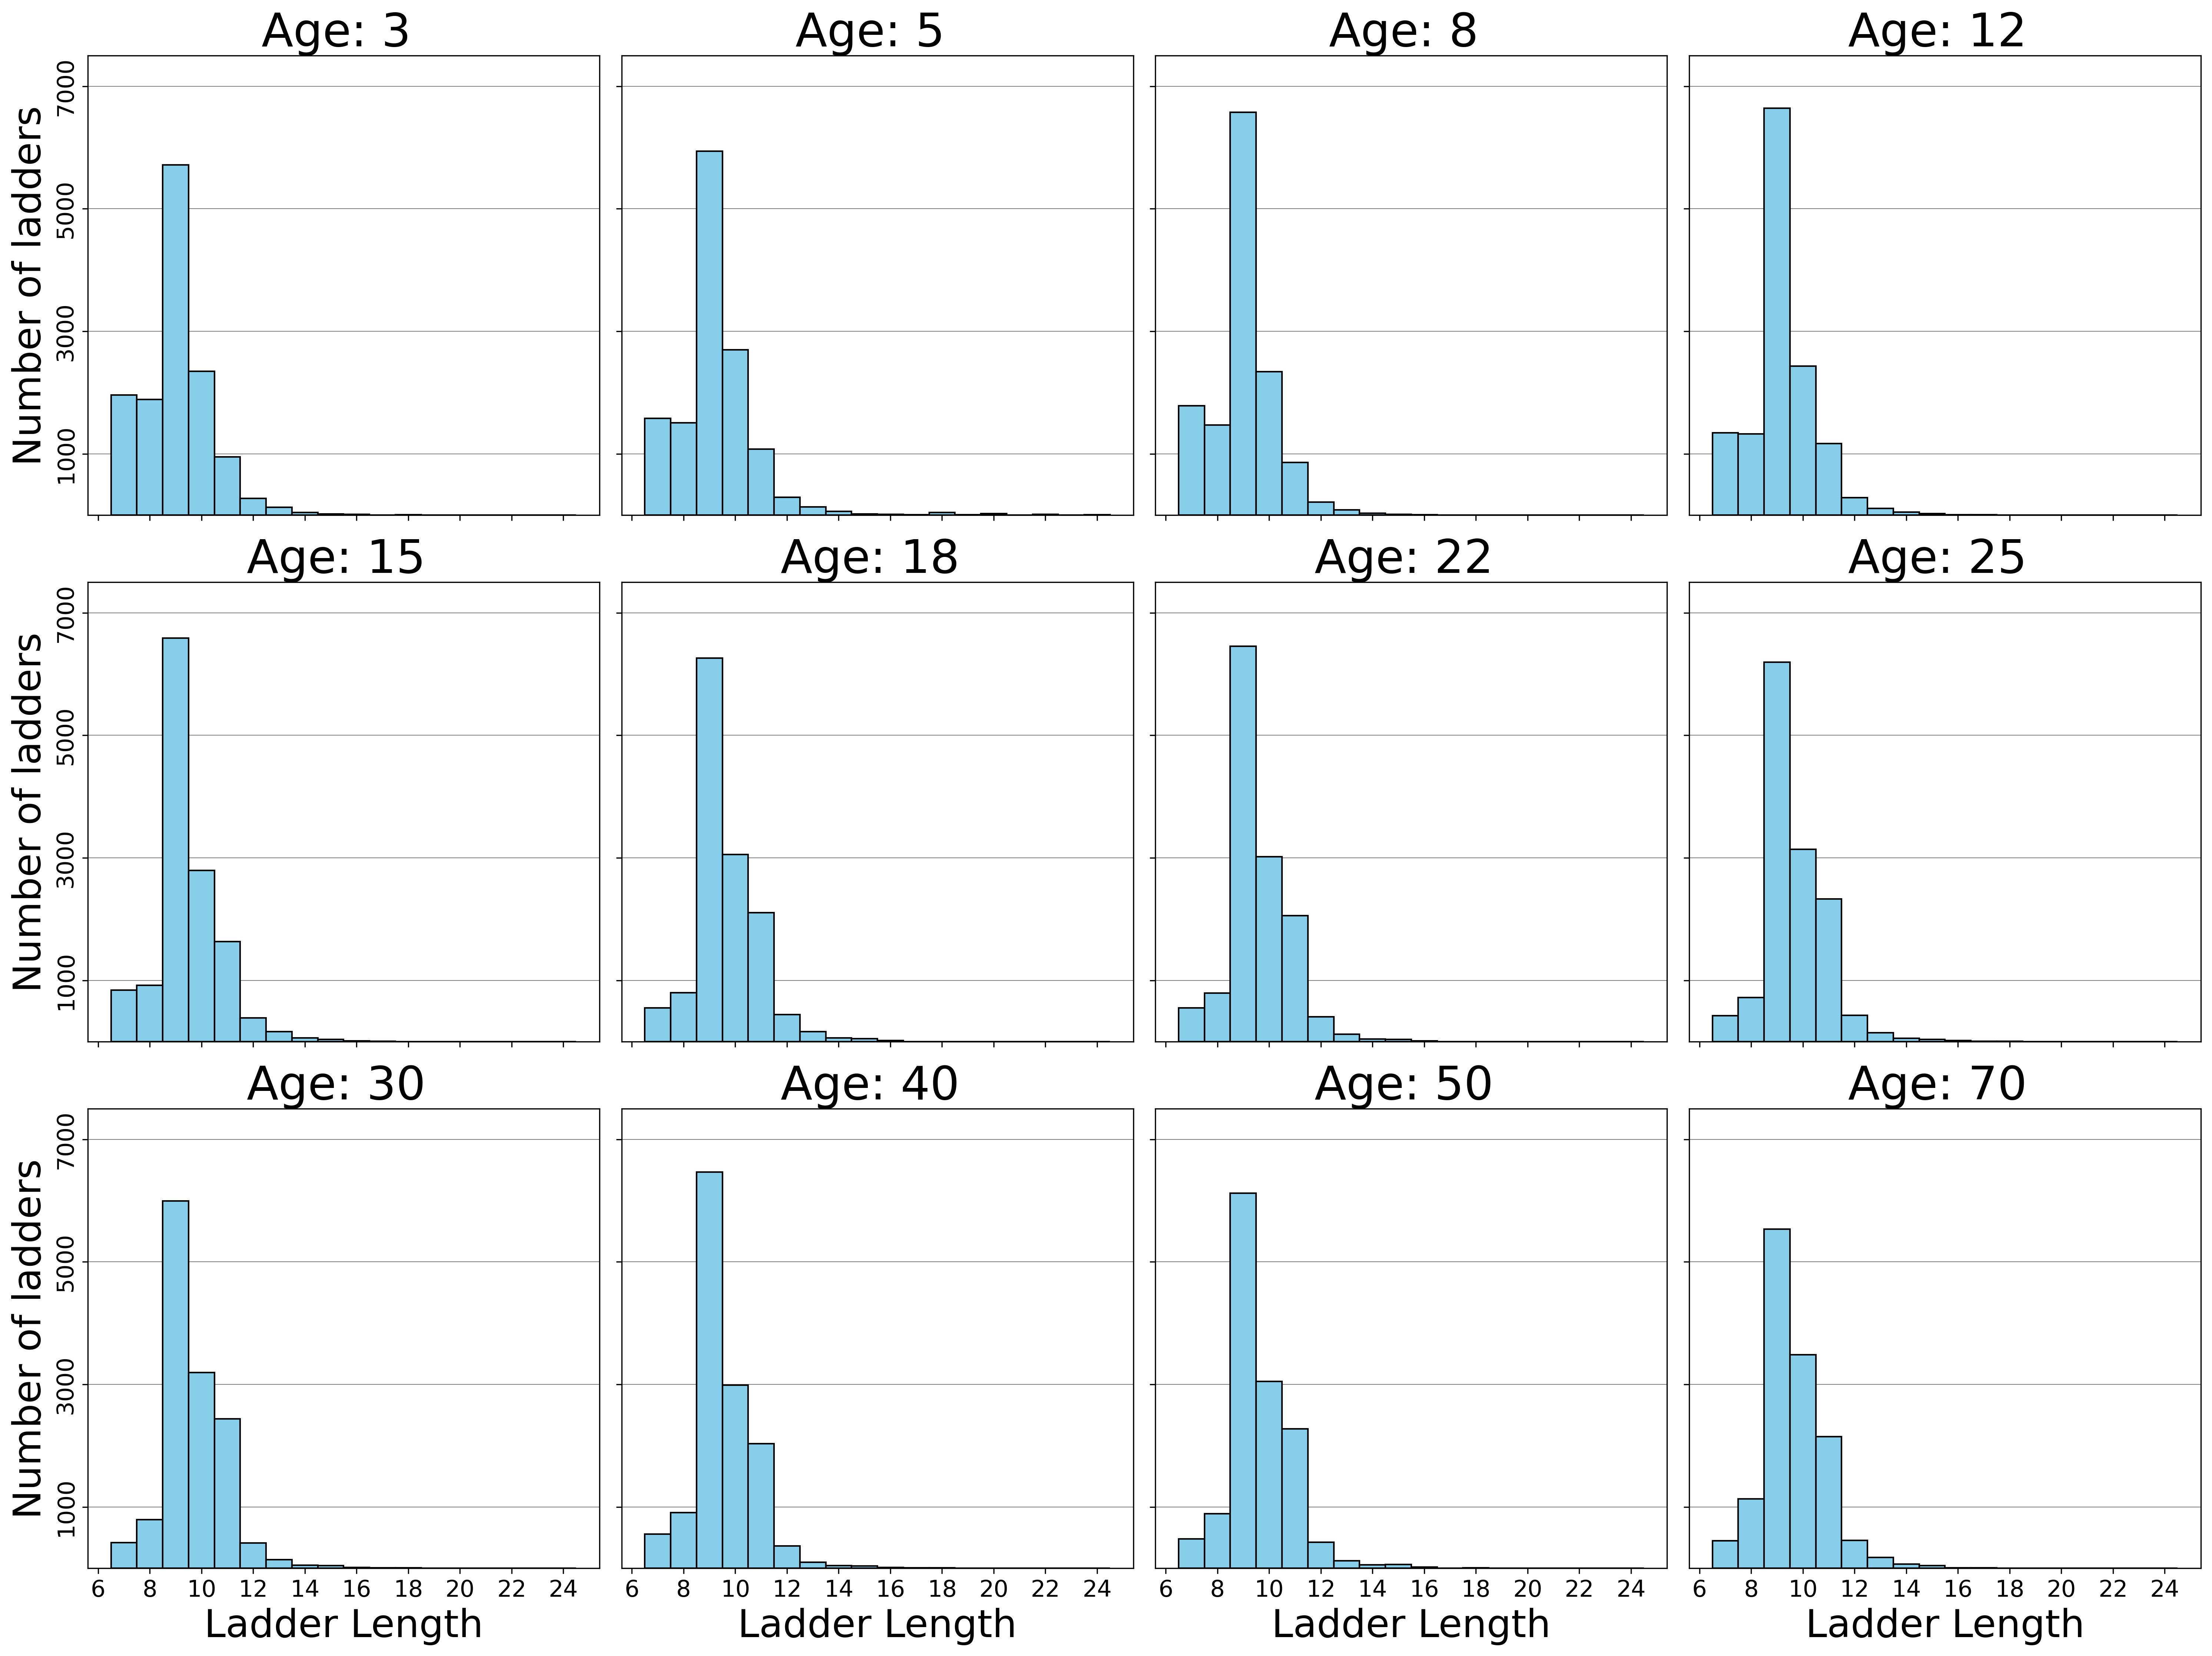

In [20]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15), dpi=300, layout="tight")
ax = ax.reshape(-1)
skipped = 0
for id, (prompt, _samples) in enumerate(all_age_prompts["generic_prompts"][None].items()):
    if "60" in prompt:
        skipped += 1
        continue
    id -= skipped
    # ax[id].hist([len(i["idxs"]) for i in _samples], bins=20, alpha=0.5, color="black")
    # ax[id].hist([len(i["list"]) for i in _samples], bins=[i + 0.5 for i in range(6, 25)], align="mid",
    #         edgecolor="black", linewidth=1, color="skyblue", alpha=1.0,)
    plot_lengths(_samples, None, ax=ax[id], high_val=7500)
    ax[id].set_title("Age: " + re.search(r"\d+ ", prompt).group(), fontsize=30)
    ax[id].set_xlabel(ax[id].get_xlabel(), fontsize=25)
    ax[id].set_ylabel(ax[id].get_ylabel(), fontsize=25)
    if id in [0, 4]:
        ax[id].set_xticklabels([])
        ax[id].set_xlabel("")
        continue
    if id < 8:
        ax[id].set_xticklabels([])
        ax[id].set_yticklabels([])
        ax[id].set_xlabel("")
        ax[id].set_ylabel("")
        continue
    if id > 8:
        ax[id].set_yticklabels([])
        ax[id].set_ylabel("")
fig.savefig("/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/all_lengths.pdf", dpi=300, bbox_inches="tight")

# List entities length

In [21]:
def get_average_entity_length(x):
    return [np.mean([len(j.split()) for j in i["list"]]) for i in x]

In [22]:
def plot_average_entity_lengths(ladder_list, output_path, ax=None, high_val=900):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_axisbelow(True)
    ax.yaxis.grid(color= 'gray', linewidth = 0.5)
    ax.hist([i for i in get_average_entity_length(ladder_list) if i > 1], bins=[i/10 for i in range(10,24)], range=(1, 2.5), align="mid",
            edgecolor="black", linewidth=1, color="coral", alpha=1.0, label="N. Ladders");
    ax.set_ylim(0, high_val)
    ax.set_xlabel("Average Entity Length", fontsize=20)
    ax.set_ylabel("Number of ladders", fontsize=20)
    ax.set_yticks([100 * i for i in range(2, 10, 2)])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, fontsize=15)
    for l in ax.get_yticklabels():
        l.set_va("center")
    # ax.legend()
    # ax.set_xticks(range(6, 25, 2));
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    if fig is not None:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    return fig, ax

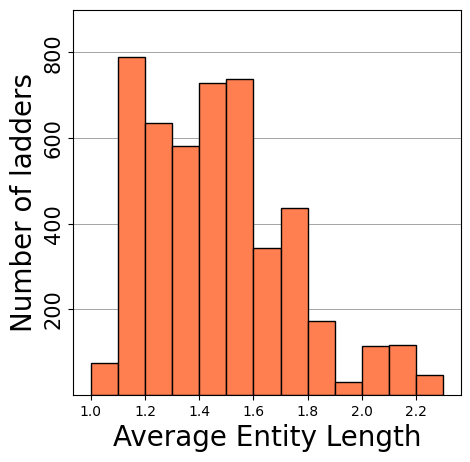

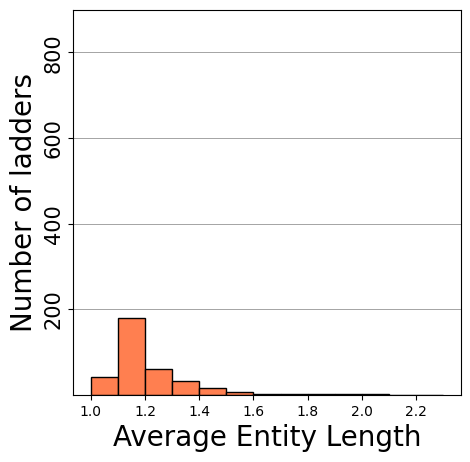

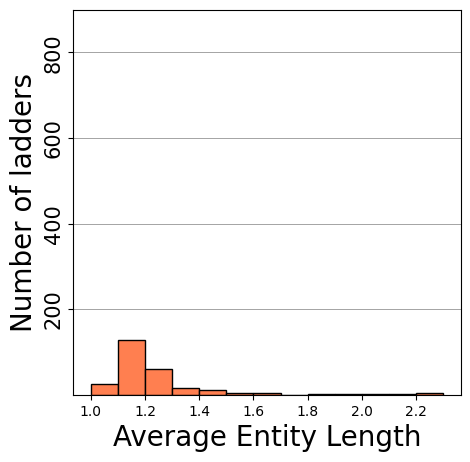

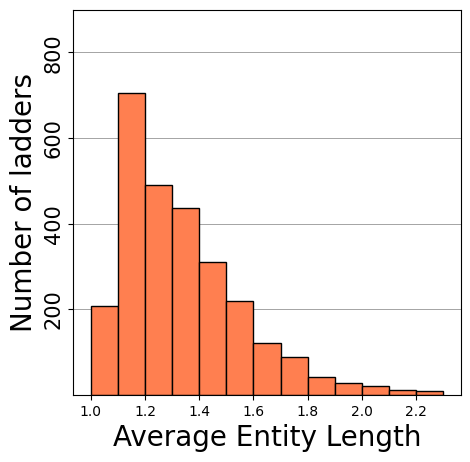

In [23]:
plot_average_entity_lengths(child_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/child_entity_length.pdf");
plot_average_entity_lengths(adult_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/adult_entity_length.pdf");
plot_average_entity_lengths(senior_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/senior_entity_length.pdf");
plot_average_entity_lengths(linguist_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/linguist_entity_length.pdf");

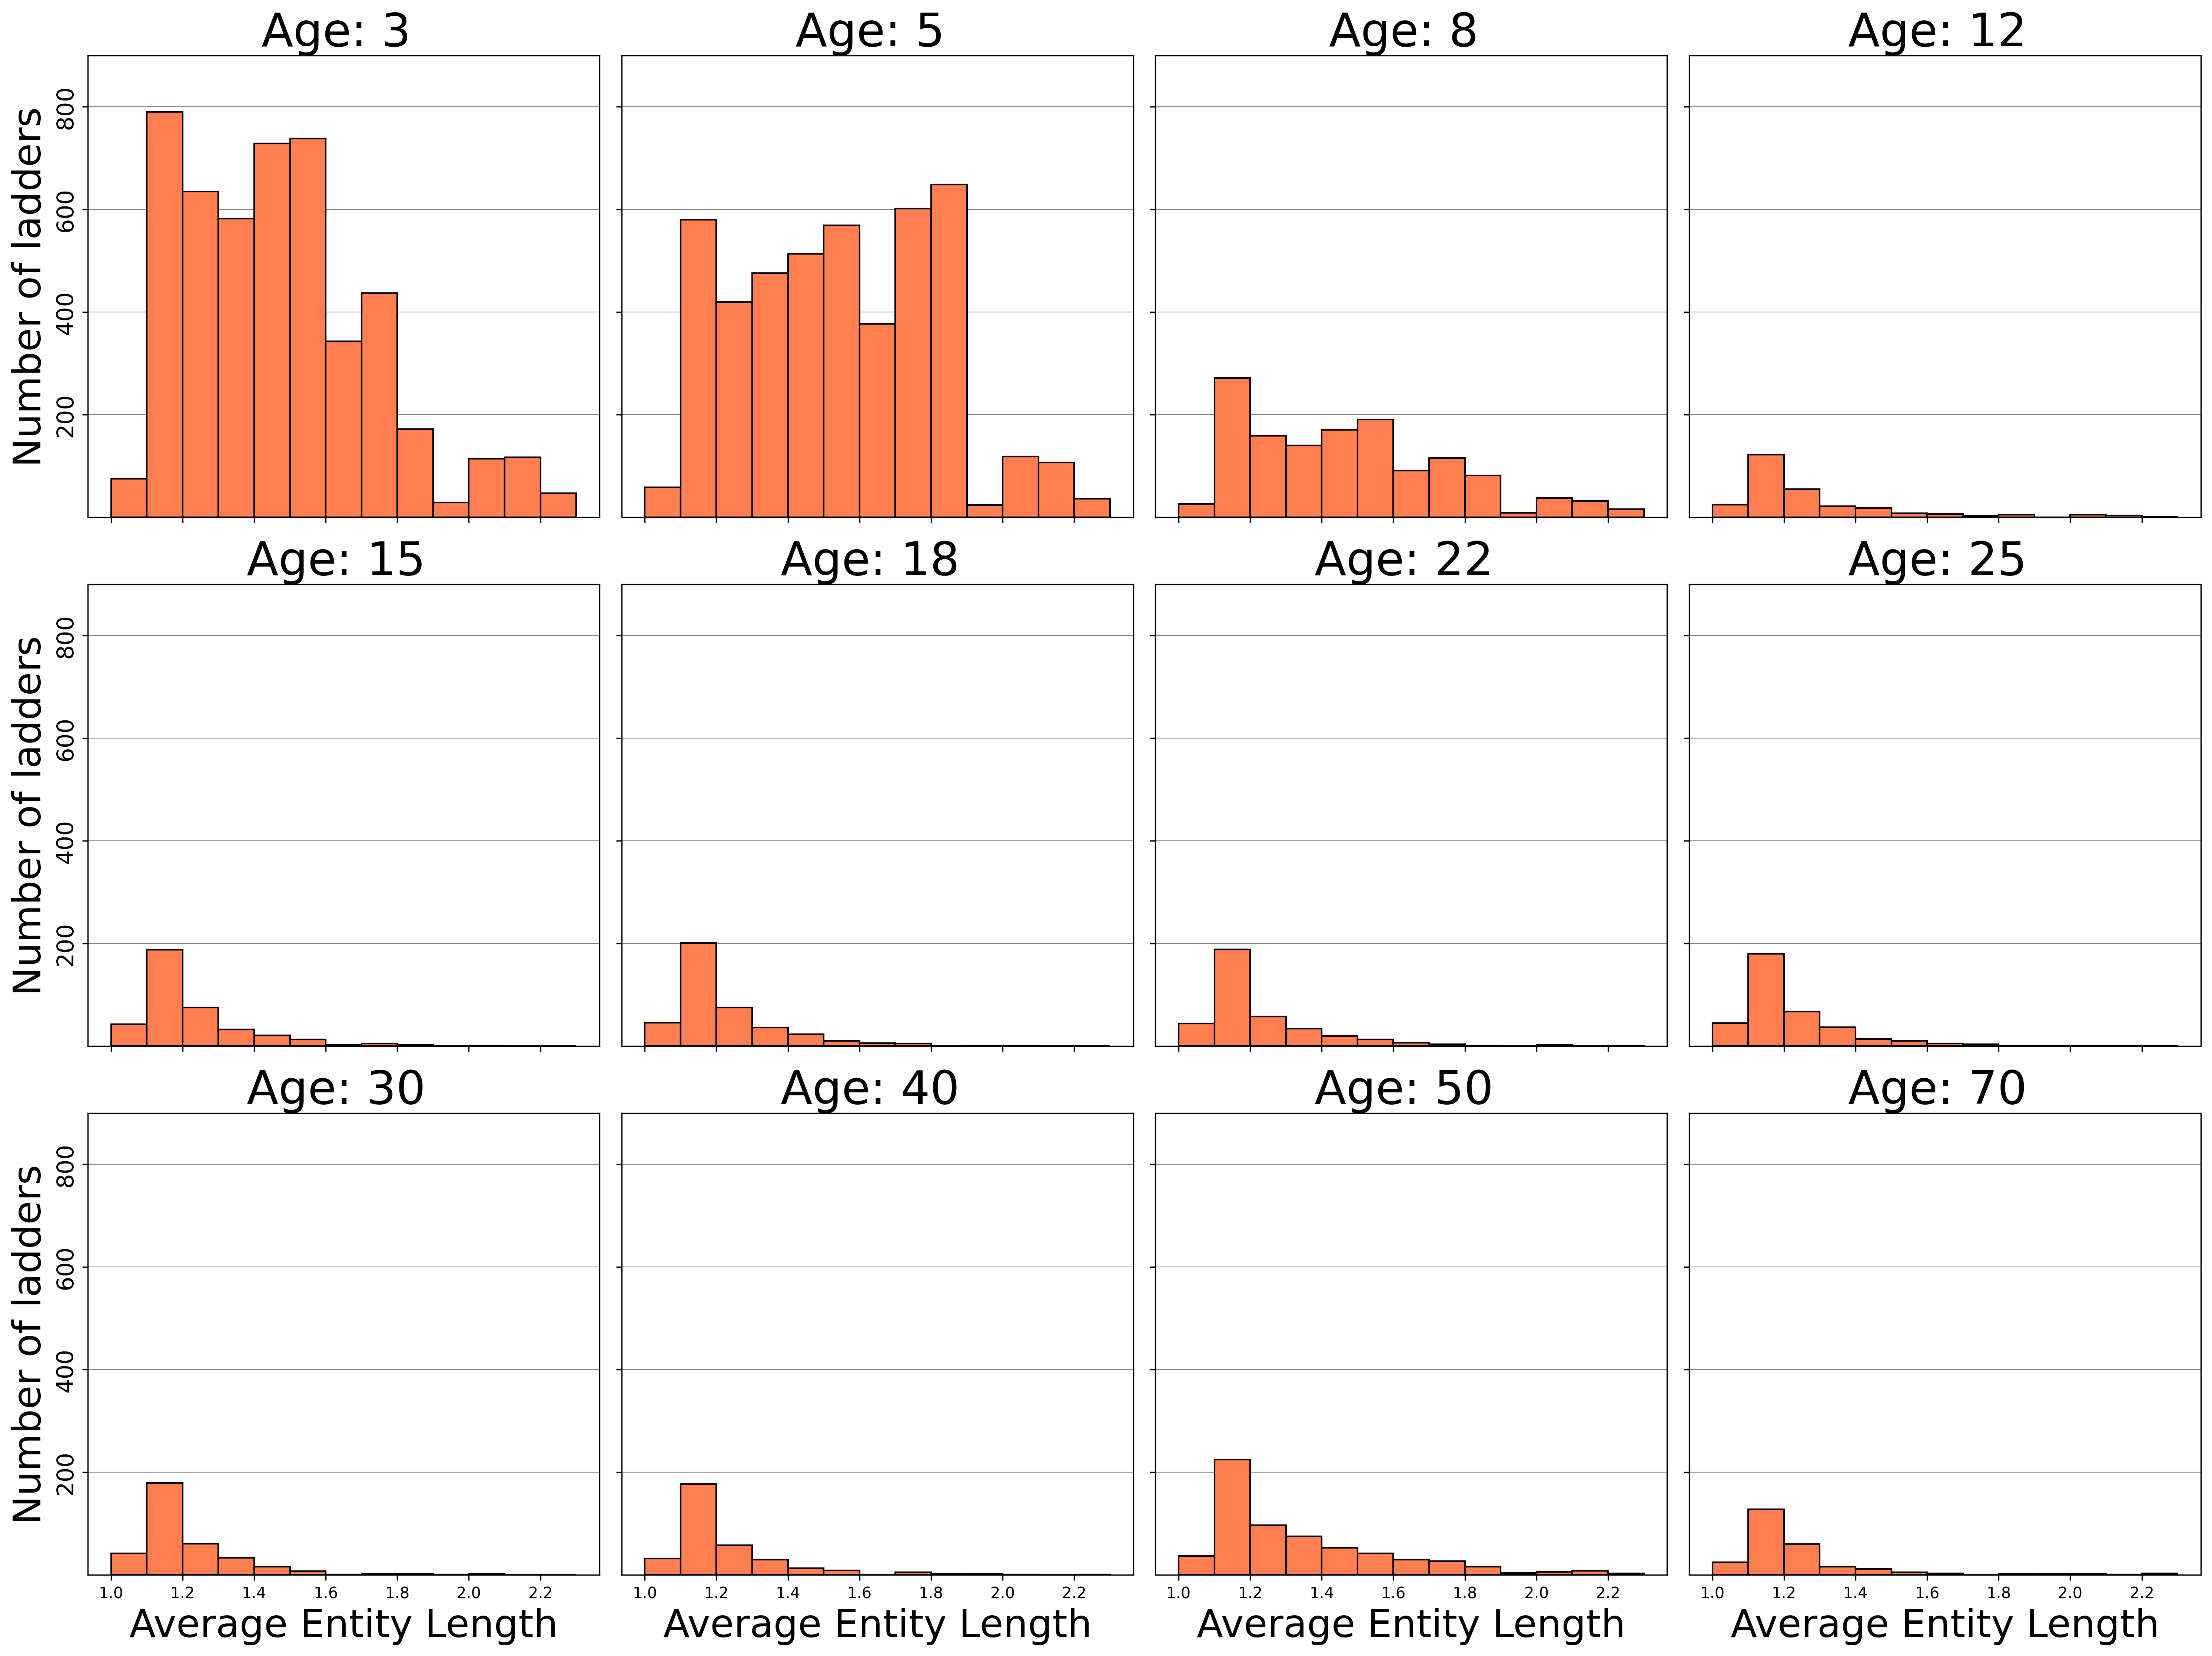

In [24]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15), dpi=300, layout="tight")
ax = ax.reshape(-1)
skipped = 0
for id, (prompt, _samples) in enumerate(all_age_prompts["generic_prompts"][None].items()):
    if "60" in prompt:
        skipped += 1
        continue
    id -= skipped
    # ax[id].hist([len(i["idxs"]) for i in _samples], bins=20, alpha=0.5, color="black")
    # ax[id].hist([len(i["list"]) for i in _samples], bins=[i + 0.5 for i in range(6, 25)], align="mid",
    #         edgecolor="black", linewidth=1, color="skyblue", alpha=1.0,)
    plot_average_entity_lengths(_samples, None, ax=ax[id], high_val=900)
    ax[id].set_title("Age: " + re.search(r"\d+ ", prompt).group(), fontsize=30)
    ax[id].set_xlabel(ax[id].get_xlabel(), fontsize=25)
    ax[id].set_ylabel(ax[id].get_ylabel(), fontsize=25)
    if id in [0, 4]:
        ax[id].set_xticklabels([])
        ax[id].set_xlabel("")
        continue
    if id < 8:
        ax[id].set_xticklabels([])
        ax[id].set_yticklabels([])
        ax[id].set_xlabel("")
        ax[id].set_ylabel("")
        continue
    if id > 8:
        ax[id].set_yticklabels([])
        ax[id].set_ylabel("")
fig.savefig("/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/all_entity_lengths.pdf", dpi=300, bbox_inches="tight")

# Concreteness

In [25]:
def plot_concreteness(ladder_list, output_path, ax=None, high_val=2500):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_axisbelow(True)
    ax.yaxis.grid(color= 'gray', linewidth = 0.5)
    ax.hist([i["list_spec_corr"] for i in ladder_list], align="mid", bins=[i/10 for i in range(-12, 12)],
            edgecolor="black", linewidth=1, color="lightseagreen", alpha=1.0, label=f"Avg. Concreteness: {np.mean([i['list_spec_corr'] for i in ladder_list]).round(2)}");
    ax.set_ylim(0, high_val)
    ax.set_xlabel("Concreteness", fontsize=20)
    ax.set_ylabel("Number of ladders", fontsize=20)
    ax.set_yticks([1000 * i for i in range(1, 1 + int(high_val / 1000))])
    # ax.set_yticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, fontsize=15)
    for l in ax.get_yticklabels():
        l.set_va("center")
    ax.set_xticks([i/10 for i in range(-10, 12, 2)]);
    labels = []
    for i in ax.get_xticklabels():
        i.set_text(i.get_text().replace("0.", ".").replace("1.0", "1"))
        labels.append(i)
        # print(i.get_text())
        # labels.append(plt.Text(i.get_text().replace("0", "")))
    ax.set_xticklabels(labels, fontsize=10, )
    ax.legend(fontsize=15)
    if fig is not None:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    return fig, ax

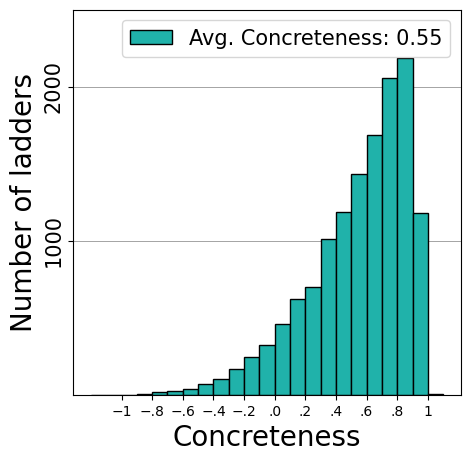

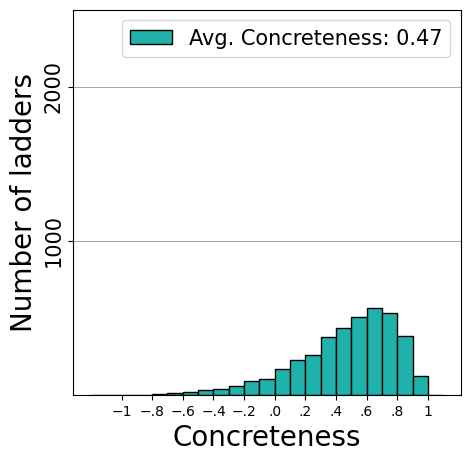

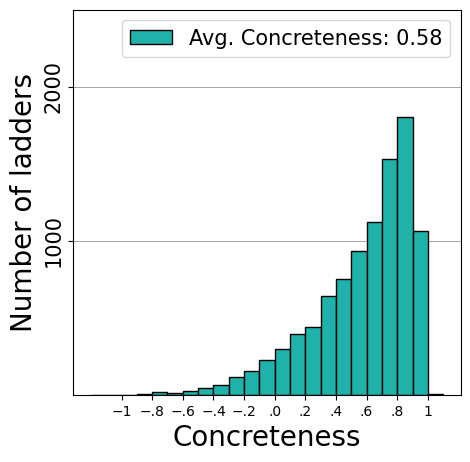

In [26]:
abstract_linguist_ladders = all_no_age_prompts["generic_prompts"]["abstract"]["You are an expert linguist analysing the abstraction and concreteness of words."]
concrete_linguist_ladders = all_no_age_prompts["generic_prompts"]["concrete"]["You are an expert linguist analysing the abstraction and concreteness of words."]
plot_concreteness(linguist_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/linguist_concreteness.pdf");
plot_concreteness(abstract_linguist_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/abstract_linguist_concreteness.pdf");
plot_concreteness(concrete_linguist_ladders, "/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/concrete_linguist_concreteness.pdf");

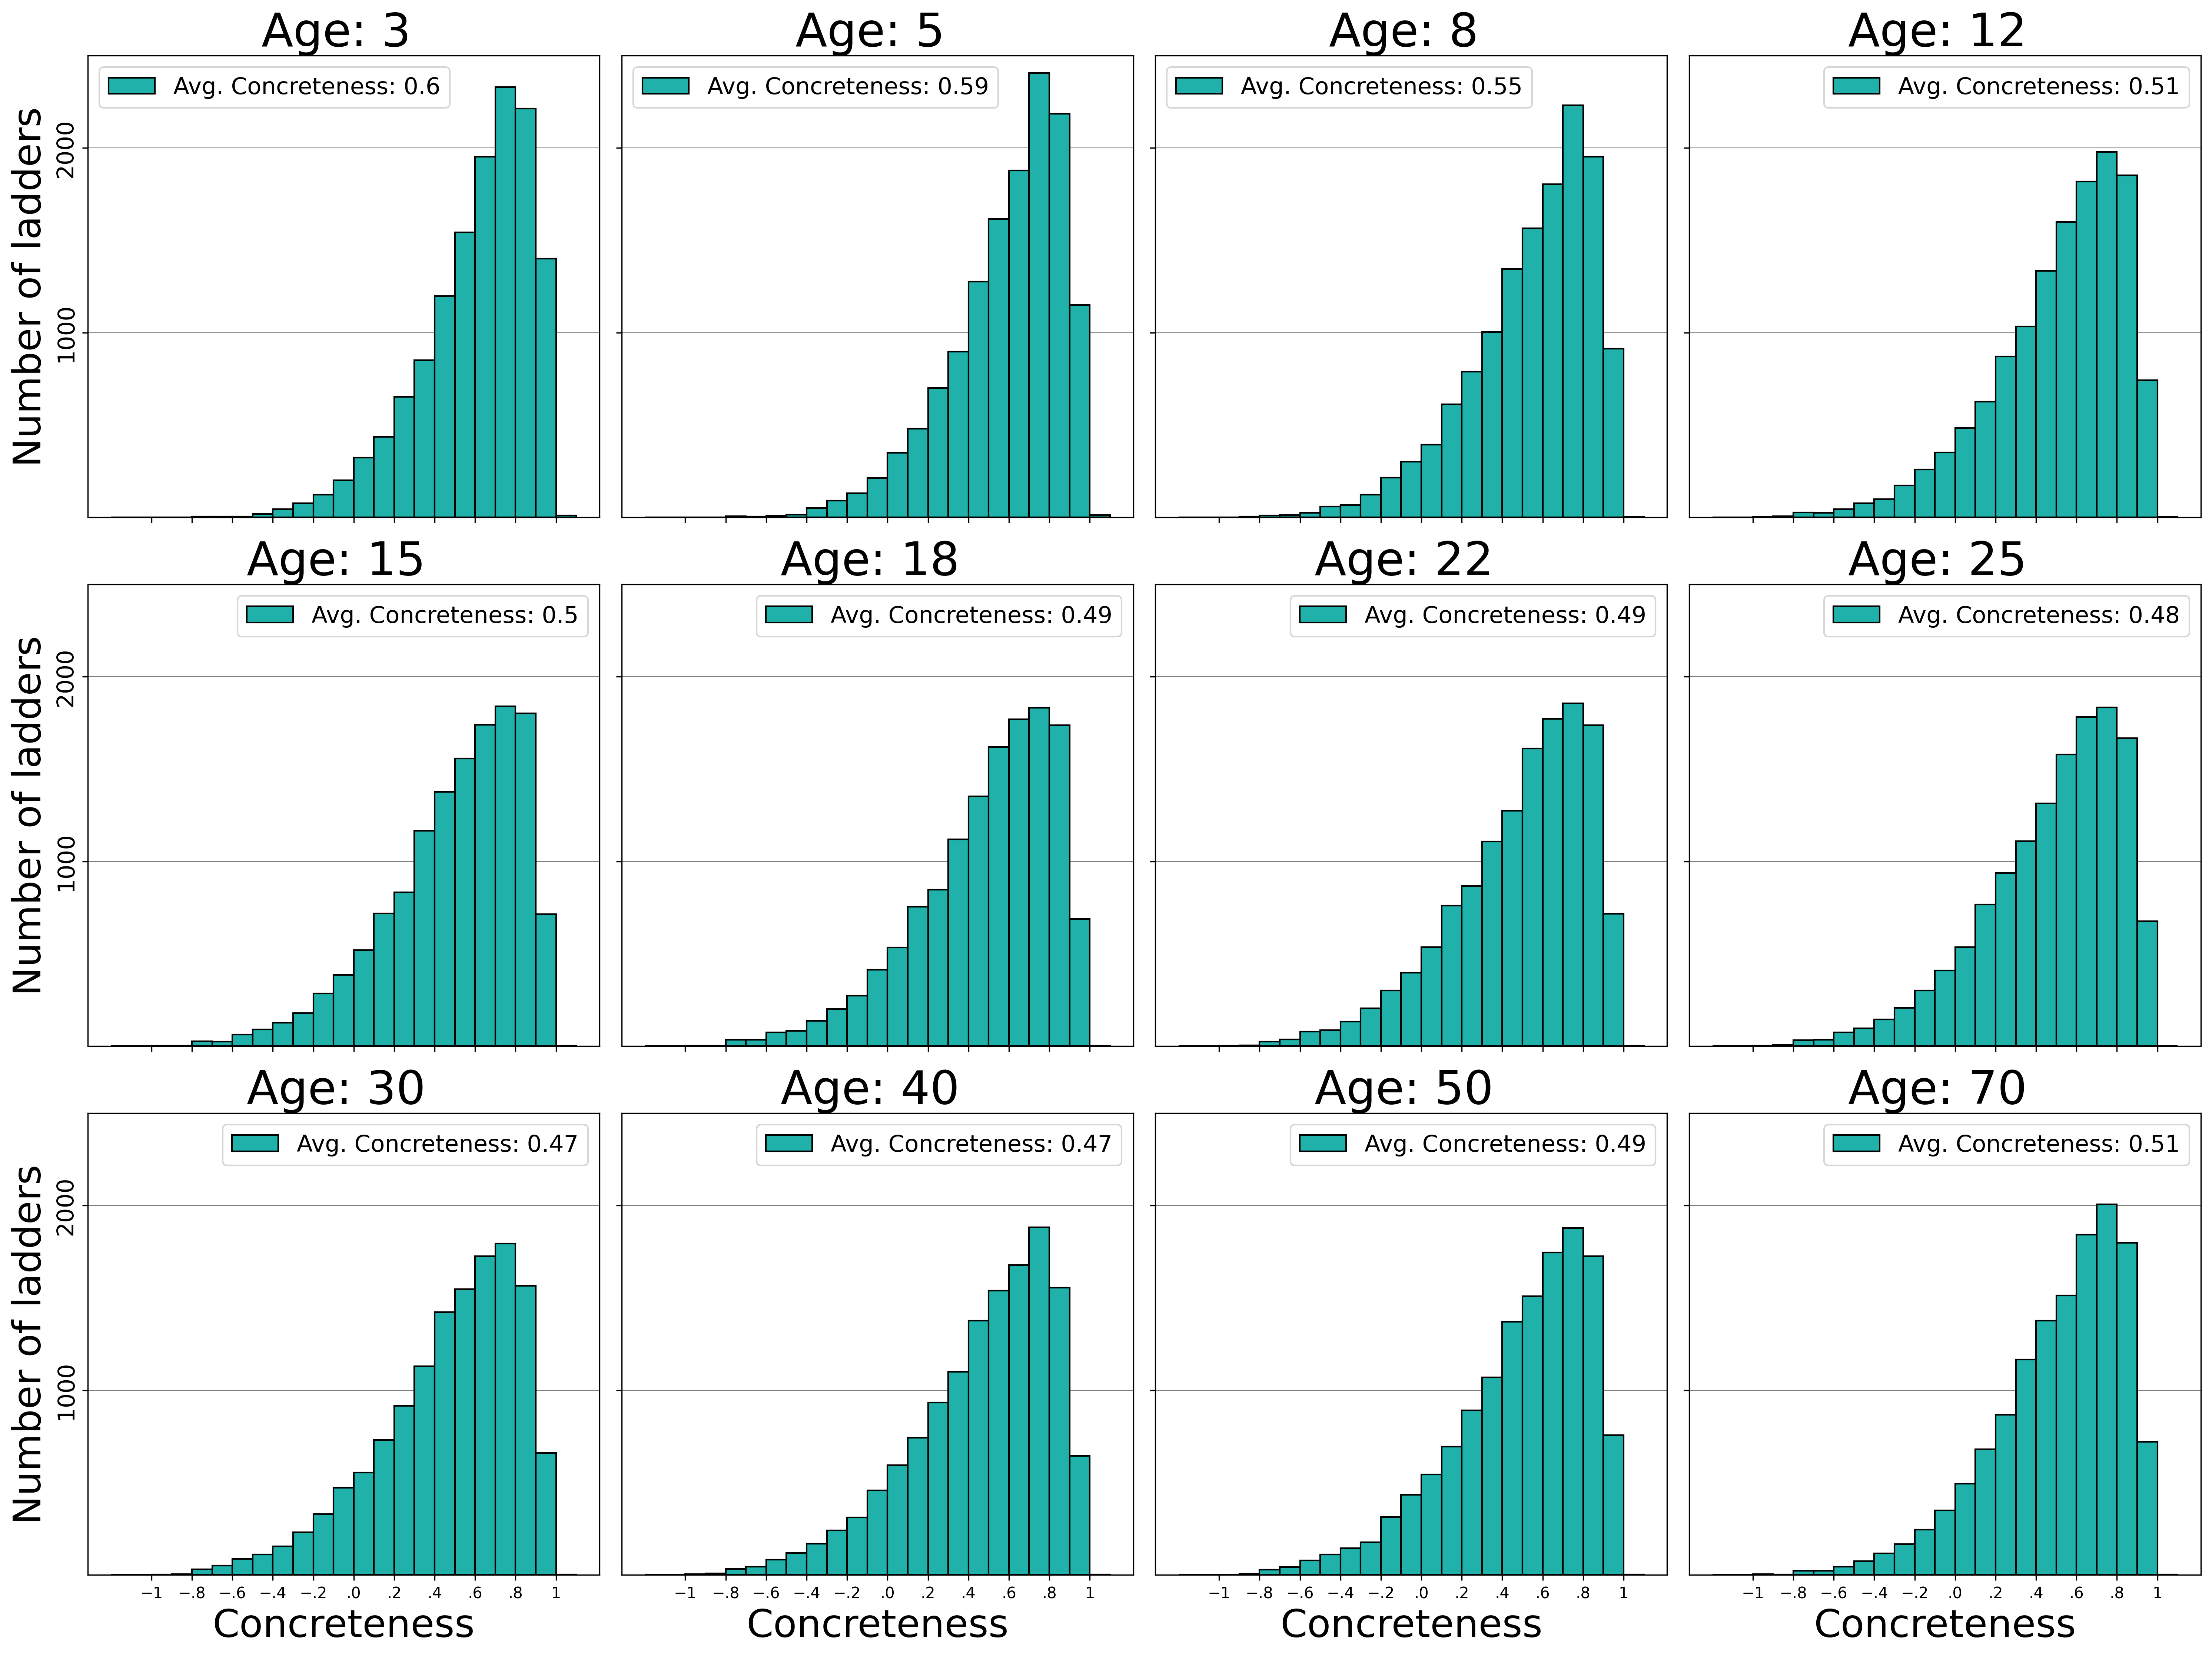

In [27]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15), dpi=300, layout="tight")
ax = ax.reshape(-1)
skipped = 0
for id, (prompt, _samples) in enumerate(all_age_prompts["generic_prompts"][None].items()):
    if "60" in prompt:
        skipped += 1
        continue
    id -= skipped
    # ax[id].hist([len(i["idxs"]) for i in _samples], bins=20, alpha=0.5, color="black")
    # ax[id].hist([i["list_spec_corr"] for i in _samples], bins=20, edgecolor="black")
    plot_concreteness(_samples, None, ax=ax[id], high_val=2500)
    ax[id].set_title("Age: " + re.search(r"\d+ ", prompt).group(), fontsize=30)
    ax[id].set_xlabel(ax[id].get_xlabel(), fontsize=25)
    ax[id].set_ylabel(ax[id].get_ylabel(), fontsize=25)
    if id in [0, 4]:
        ax[id].set_xticklabels([])
        ax[id].set_xlabel("")
        continue
    if id < 8:
        ax[id].set_xticklabels([])
        ax[id].set_yticklabels([])
        ax[id].set_xlabel("")
        ax[id].set_ylabel("")
        continue
    if id > 8:
        ax[id].set_yticklabels([])
        ax[id].set_ylabel("")
fig.savefig("/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/age_all_entity_concreteness.pdf", dpi=300, bbox_inches="tight")

In [133]:
def get_box_plots(x, names=None, ax=None, output_path="test.pdf", legend_kwargs={}):
    if names is None:
        names = [str(i) for i in range(len(x))]
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
    for id, (name, series) in enumerate(x.items()):
        sns.boxplot(x=id, y=series, label=name, ax=ax, patch_artist=True, legend=False)
    if len(legend_kwargs) > 0:
        ax.legend(**legend_kwargs)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
    if fig is not None:
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
    return fig, ax

/tmp/ipykernel_5469/2857812337.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


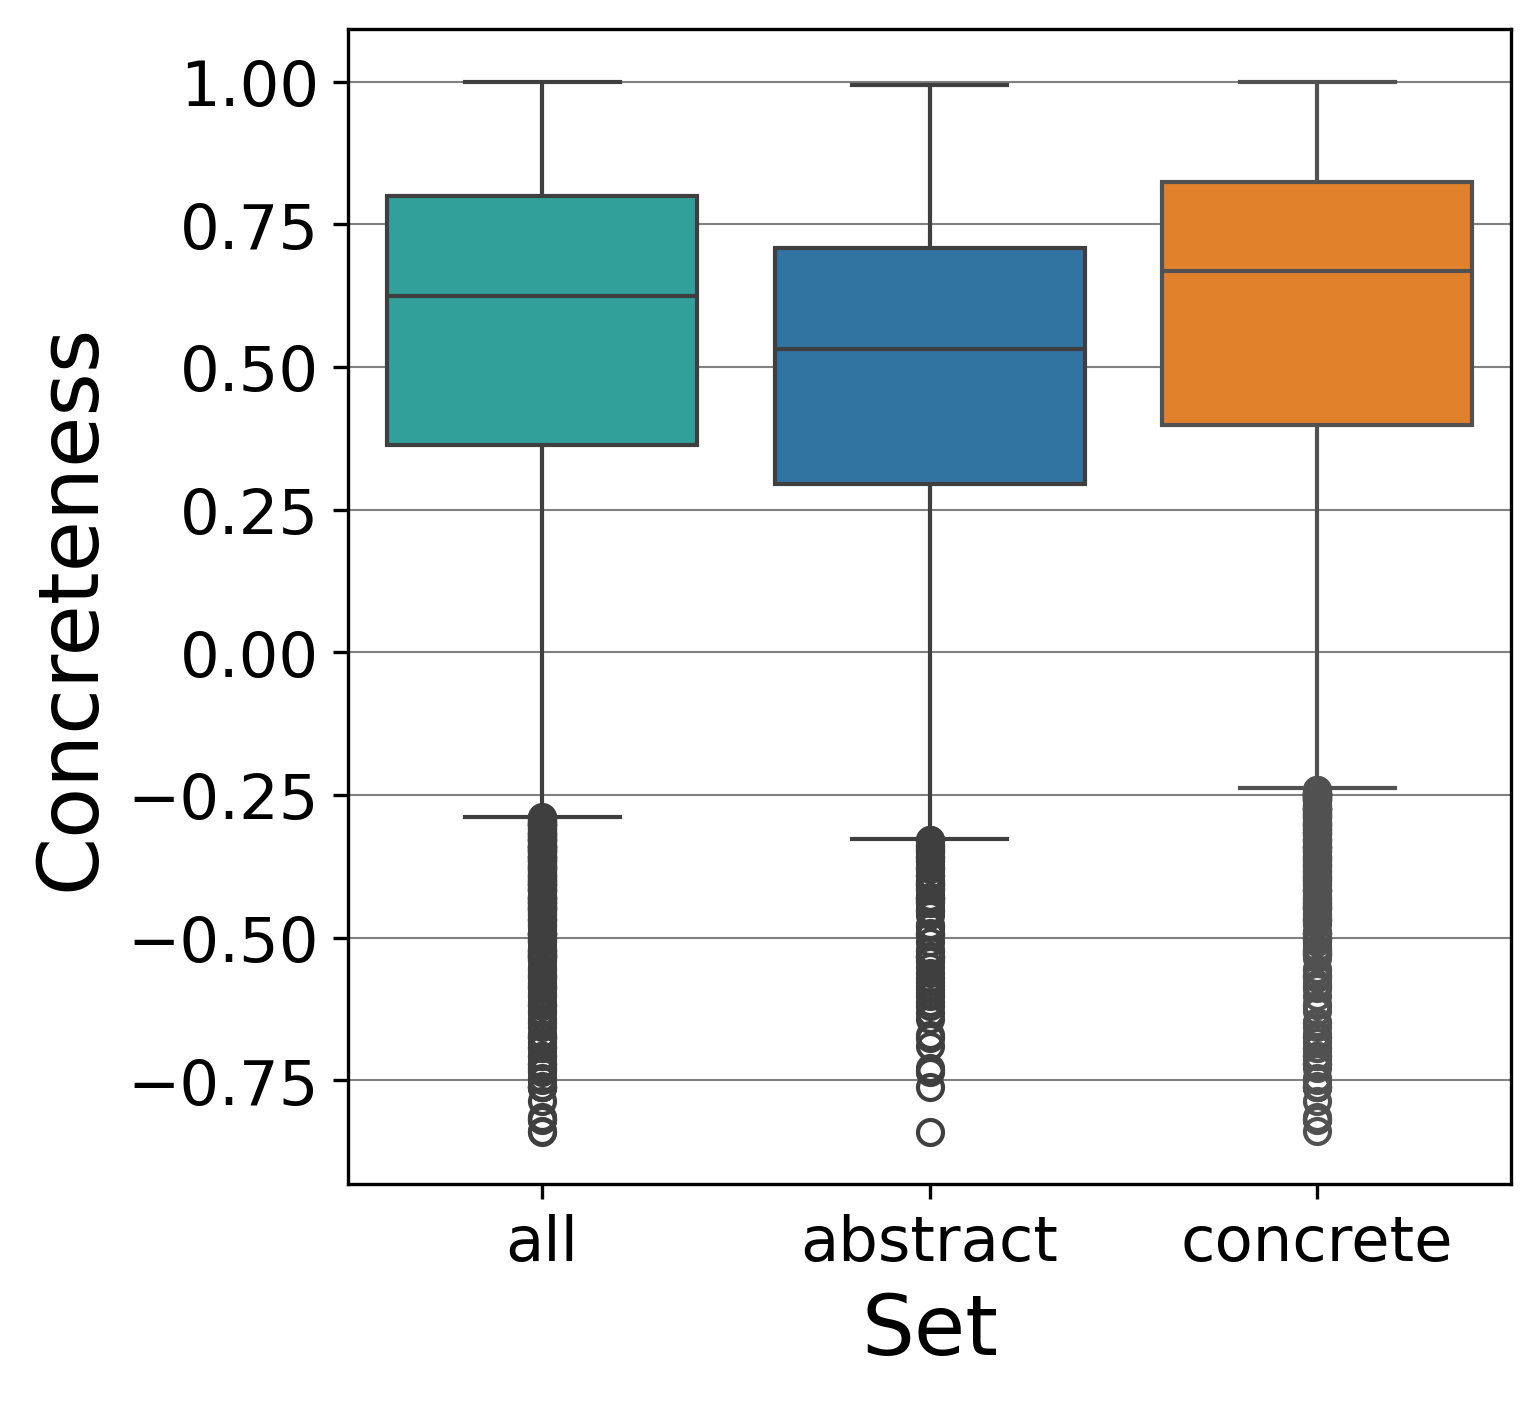

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color= 'gray', linewidth = 0.5)
sns.boxplot(x=-1, y=[i["list_spec_corr"] for i in linguist_ladders], label="all", ax=ax, color='lightseagreen', legend=False)
get_box_plots({
        "abstract":[i["list_spec_corr"] for i in abstract_linguist_ladders],
        "concrete":[i["list_spec_corr"] for i in concrete_linguist_ladders]},
    # legend_kwargs={"loc":"upper center", "bbox_to_anchor":(0.45, 1.15), "ncol":3, "fontsize":15},
    ax=ax)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["all", "abstract", "concrete"], fontsize=15)
ax.set_xlabel("Set", fontsize=20)
ax.set_ylabel("Concreteness", fontsize=20)
fig.savefig("/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/boxplot_linguist_concreteness.pdf", dpi=300, bbox_inches="tight")

/tmp/ipykernel_5469/2857812337.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


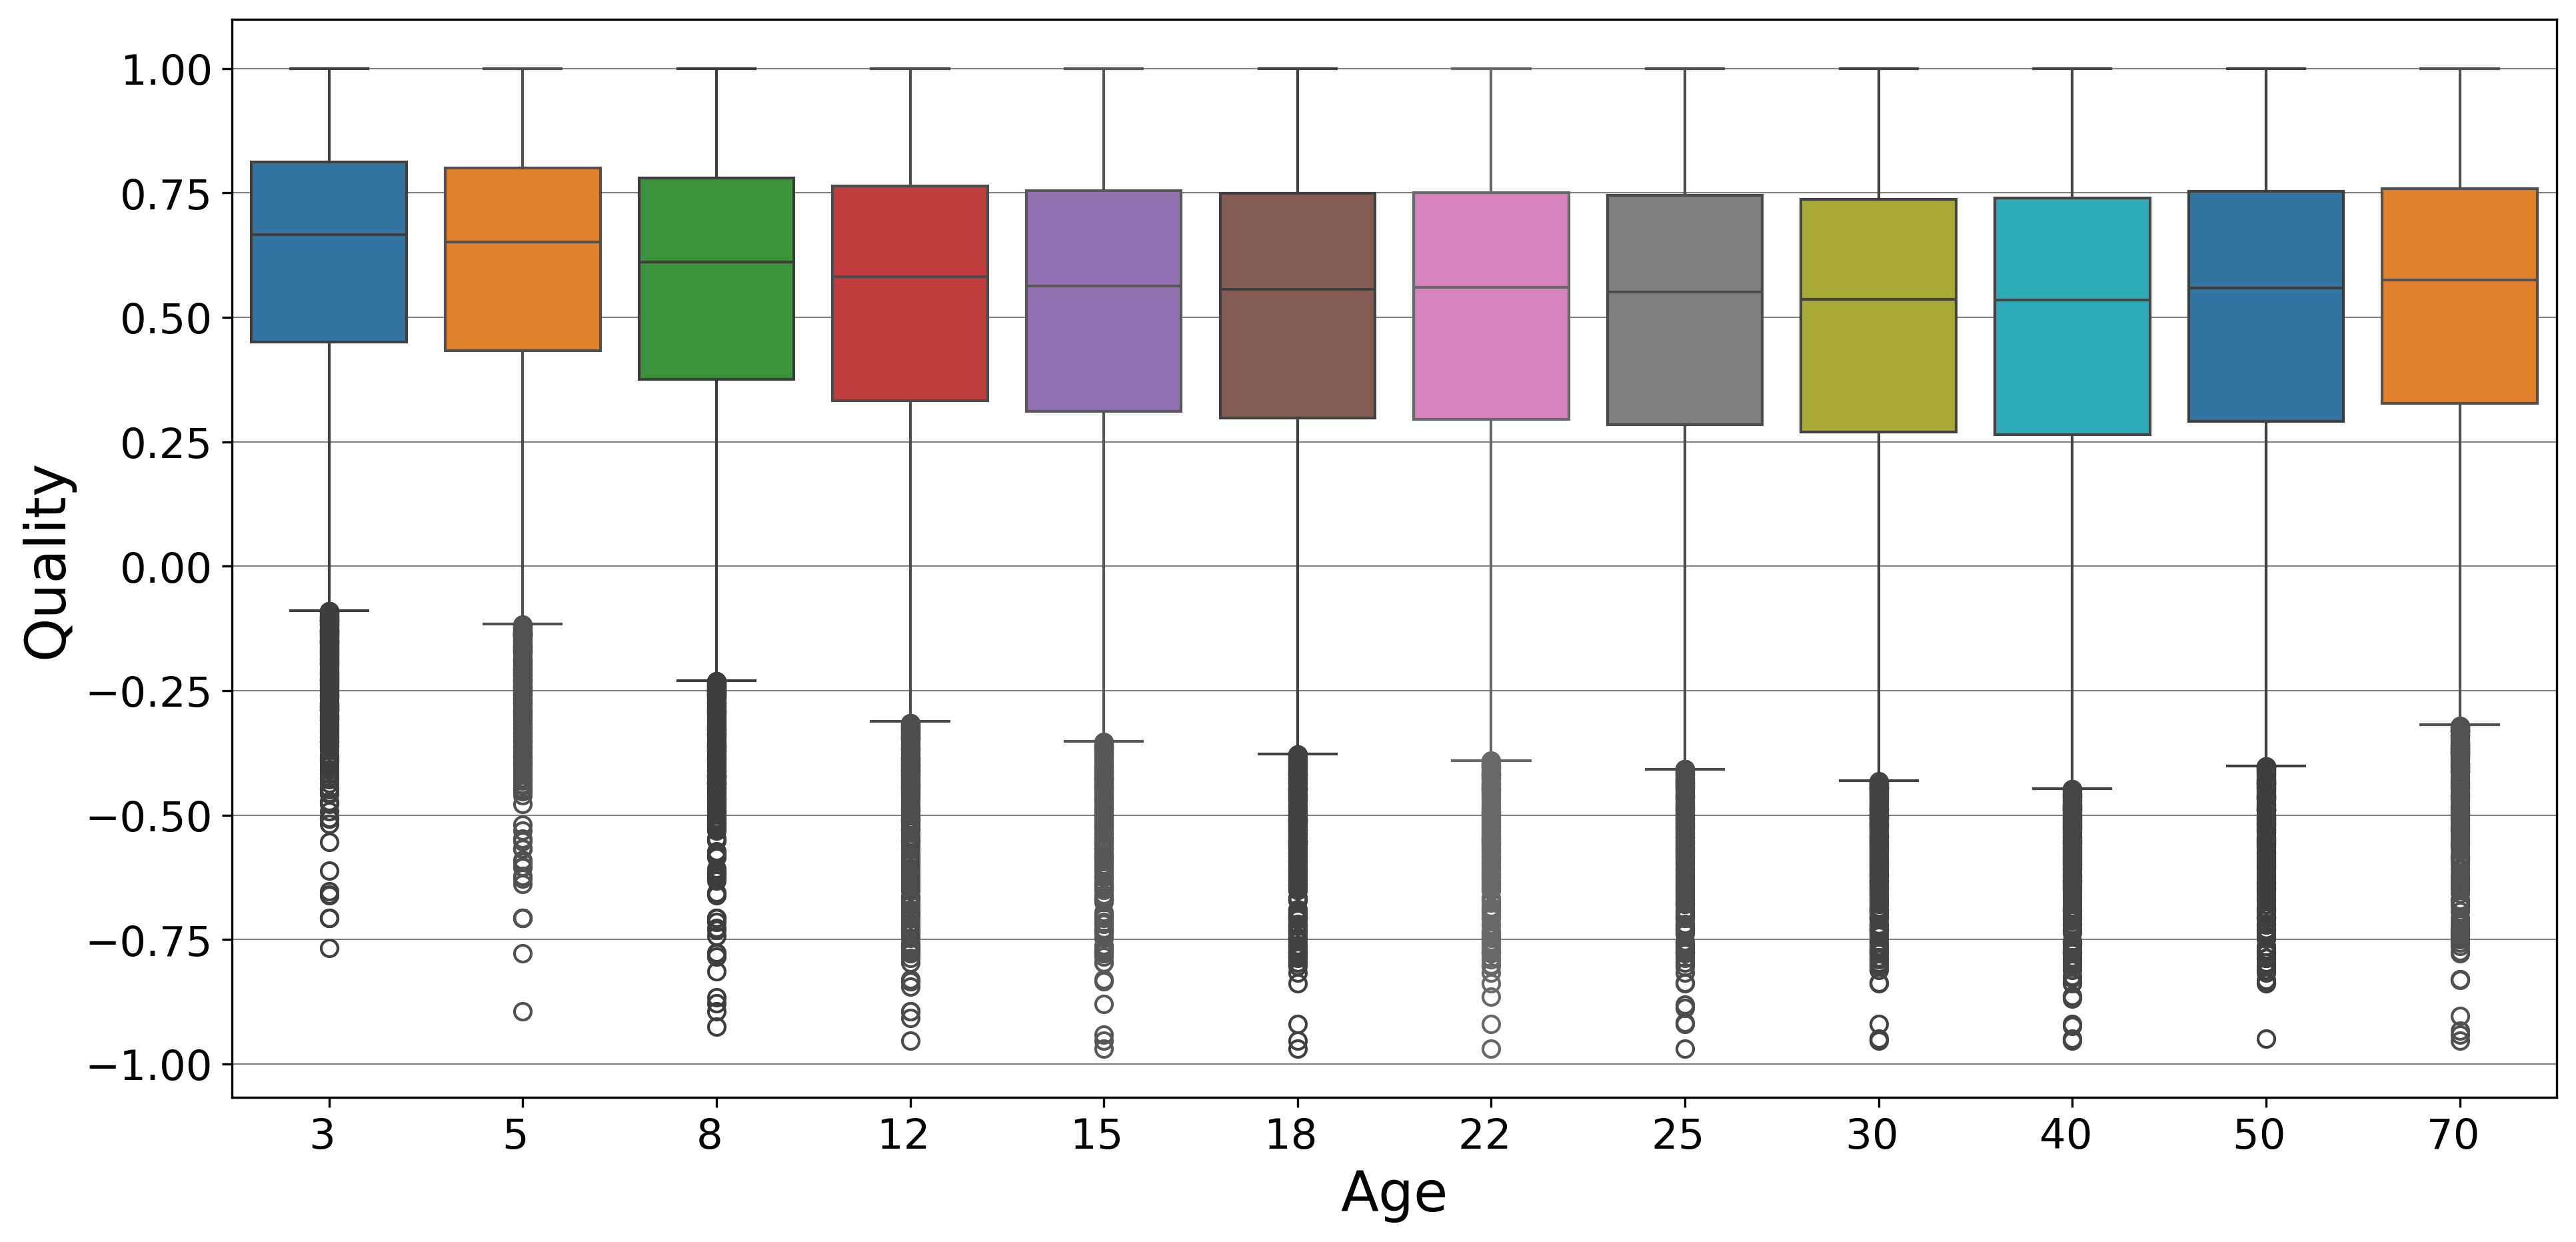

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color= 'gray', linewidth = 0.5)
get_box_plots(
    {
        f"Age {re.search(r'\d+ ',j).group(0)}":[h["list_spec_corr"] for h in i]
        for j, i in all_age_prompts["generic_prompts"][None].items() if "60" not in j},
    ax=ax,
    # legend_kwargs={"loc":"upper center", "bbox_to_anchor":(0.5, 1.16), "ncol":6, "fontsize":15}
    )
ax.set_xticks(range(0, len(all_age_prompts["generic_prompts"][None]) - 1))
ax.set_xticklabels([re.search(r'\d+ ',j).group(0) for j in all_age_prompts["generic_prompts"][None] if "60" not in j], fontsize=15)
ax.set_xlabel("Age", fontsize=20)
ax.set_ylabel("Quality", fontsize=20)
fig.savefig("/home/giovanni/Latex/ladders_wordnet_conference_2025/plots/boxplot_age_concreteness.pdf", dpi=300, bbox_inches="tight")

In [86]:
kruskal(
    [i["list_spec_corr"] for i in linguist_ladders], 
    [i["list_spec_corr"] for i in abstract_linguist_ladders], 
    [i["list_spec_corr"] for i in concrete_linguist_ladders])

KruskalResult(statistic=np.float64(378.6195432534211), pvalue=np.float64(6.078701425263794e-83))

# MORE ...

In [34]:
# data["generic_prompts"]
child_prompt = [i for i in data["generic_prompts"] if " 3 " in i][0]
senior_prompt = [i for i in data["generic_prompts"] if " 40 " in i][0]
child_out = data["generic_prompts"][child_prompt]
senior_out = data["generic_prompts"][senior_prompt]

In [35]:
idx = 10104
child_sample = child_out[idx]
senior_sample = [i for i in senior_out if i["token"] == child_sample["token"]][0]

print(child_sample["token"], senior_sample["token"])
print(child_sample["list_spec_corr"])
print(list(zip(child_sample["list"], child_sample["list_spec"])))
print(child_sample["generated_text"])
print("\t", child_sample["idxs"])
print()
print(senior_sample["list_spec_corr"])
print(senior_sample["generated_text"])
print(list(zip(senior_sample["list"], senior_sample["list_spec"])))
print("\t", senior_sample["idxs"])

scooter scooter
0.8986843649392482
[('thing', 1.25), ('toy', 1.25), ('vehicle', 1.75), ('scooter', 3.0), ('motorcycle-scooter', 0), ('electric scooter', 0), ('razor scooter', 0), ('pink razor scooter', 0)]
- Thing - Toy - Vehicle - Scooter - Motorcycle-scooter - Electric scooter - Razor scooter - Pink razor scooter
	 [0, 1, 2, 3]

0.3866276876507055
Here's a list of single word concepts around the word 'scooter': • Vehicle • Transport • Machine • Device • Scooter • Moped • Vespa • Unicycle • Segway
[('vehicle', 1.75), ('transport', 1.5), ('machine', 1.75), ('device', 1.5), ('scooter', 3.0), ('moped', 3.5), ('vespa', 1.75), ('unicycle', 2.5), ('segway', 2.0)]
	 [0, 1, 2, 3, 4, 5, 6, 7, 8]
